### ライブラリのimport

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from preprocessing.calculate_bmi_bmr_bsa_category import calculate_bmi_bmr_bsa_category
%matplotlib inline

## 解析用の元データを読み込み

In [86]:
df = pd.read_excel('preprocessed_train_data.xlsx')
df.head()

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,...,Mean CTDIvol,DLP,study_date,id,age,gender,height_cm,weight_kg,scan_area,scan_method
0,1103161420210101,5.1 QQ Chest Routine,NaN,Chest,382.14,100,350.24,640,1.38,80,...,5.86,223.82,2021-01-01,12585,86,F,150.0,49.1,胸部CT,単純
1,1103161620210101,5.1 QQ Chest Routine,NaN,Chest,442.20,100,442.93,700,1.38,80,...,7.41,327.55,2021-01-01,2145609,61,M,163.0,74.0,胸部CT,単純
2,1103339220210102,5.1 QQ Chest Routine,NaN,Chest,467.06,100,306.59,700,1.38,80,...,5.13,239.47,2021-01-02,12615,46,M,178.0,68.0,胸部CT,単純
3,1103327120210102,5.1 QQ Chest Routine,NaN,Chest,472.12,100,433.42,700,1.38,80,...,7.25,342.20,2021-01-02,12616,52,M,182.0,70.0,胸部CT,単純
4,1103481920210103,5.1 QQ Chest Routine,NaN,Chest,462.22,100,691.26,700,1.38,80,...,11.56,534.33,2021-01-03,9595120,52,M,175.0,112.0,胸部CT,単純


## 　新たな特徴量を作成

* BMI(Body Mass Index)  
  $BMI = weight(kg) / height(m)^2$  
  
* BMR(Basal Metabolic Rate: 基礎代謝率): 年齢、性別、身長、体重に基づいて計算される。ハリス・ベネディクト方程式と呼ばれる  
  男性$BMR=66.47 + (13.75*weight[kg]) + (5.003*height[cm]) - (6.755*age[歳])$  
  女性$BMR=655.1 + (9.563*weight[kg]) + (1.85*height[cm]) - (4.676*age[歳])$  
  
* 体格指数(Rohrer's index) ：学童期に適するとあるので、今回は使わない  
  $Rohrer's index = weight[kg] / height[m]^3$

体格指数（BMI）: 体重（kg）を身長（m）の二乗で割ったもので、以下のように分類されます（成人向けのWHOのガイドライン）。

18.5未満: 低体重（痩せ型）: underweight    
18.5～24.9: 標準体重: normal weight   
25.0～29.9: 肥満（1度）:obesity class1  
30.0～34.9: 肥満（2度）:obesity class2  
35.0～39.9: 肥満（3度）:obesity class3    
40以上: 肥満（4度、重症）:obesity class4

#### 体表面積を作成　　

体表面積 (m2
 )=0.007184×身長(cm) 
^0.725
 ×体重(kg)^
0.425

In [87]:
calculate_bmi_bmr_bsa_category(df)

In [88]:
df.head()

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,...,age,gender,height_cm,weight_kg,scan_area,scan_method,bmi,bmr,category_bmi,body_surface_area
0,1103161420210101,5.1 QQ Chest Routine,NaN,Chest,382.14,100,350.24,640,1.38,80,...,86,F,150.0,49.1,胸部CT,単純,21.82,1000.01,normal weight,1.421484
1,1103161620210101,5.1 QQ Chest Routine,NaN,Chest,442.20,100,442.93,700,1.38,80,...,61,M,163.0,74.0,胸部CT,単純,27.85,1487.40,obesity class1,1.797322
2,1103339220210102,5.1 QQ Chest Routine,NaN,Chest,467.06,100,306.59,700,1.38,80,...,46,M,178.0,68.0,胸部CT,単純,21.46,1581.27,normal weight,1.848150
3,1103327120210102,5.1 QQ Chest Routine,NaN,Chest,472.12,100,433.42,700,1.38,80,...,52,M,182.0,70.0,胸部CT,単純,21.13,1588.26,normal weight,1.901449
4,1103481920210103,5.1 QQ Chest Routine,NaN,Chest,462.22,100,691.26,700,1.38,80,...,52,M,175.0,112.0,胸部CT,単純,36.57,2130.73,obesity class3,2.256766


### 年代を追加

In [89]:
df['age_era'] = (df['age'] // 10) * 10

### scan_areaとscan_method(例：胸部CTx単純)をクロス集計

In [90]:
# クロス集計表の出現割合
cat_1 = 'scan_area'
cat_2 = 'scan_method'
X_cross = pd.crosstab(df[cat_1], df[cat_2], normalize='index')
X_cross = X_cross.reset_index()

# クロス集計表のテーブルへの変換
X_tbl = pd.melt(X_cross, id_vars=cat_1, value_name=f'rate_{cat_1} x {cat_2}')

# 出現割合の特徴量追加
df = pd.merge(df, X_tbl, on=[cat_1, cat_2], how='left')

### category_bmiとgenderのクロス集計

In [91]:
# クロス集計表の出現割合
cat_1 = 'category_bmi'
cat_2 = 'gender'
X_cross = pd.crosstab(df[cat_1], df[cat_2], normalize='index')
X_cross = X_cross.reset_index()

# クロス集計表のテーブルへの変換
X_tbl = pd.melt(X_cross, id_vars=cat_1, value_name=f'rate_{cat_1} x {cat_2}')

# 出現割合の特徴量追加
df = pd.merge(df, X_tbl, on=[cat_1, cat_2], how='left')

### category_bmiとage_eraのクロス集計

In [92]:
# クロス集計表の出現割合
cat_1 = 'age_era'
cat_2 = 'category_bmi'
X_cross = pd.crosstab(df[cat_1], df[cat_2], normalize='index')
X_cross = X_cross.reset_index()

# クロス集計表のテーブルへの変換
X_tbl = pd.melt(X_cross, id_vars=cat_1, value_name=f'rate_{cat_1} x {cat_2}')

# 出現割合の特徴量追加
df = pd.merge(df, X_tbl, on=[cat_1, cat_2], how='left')

In [93]:
df.head()

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,...,scan_area,scan_method,bmi,bmr,category_bmi,body_surface_area,age_era,rate_scan_area x scan_method,rate_category_bmi x gender,rate_age_era x category_bmi
0,1103161420210101,5.1 QQ Chest Routine,NaN,Chest,382.14,100,350.24,640,1.38,80,...,胸部CT,単純,21.82,1000.01,normal weight,1.421484,80,0.973792,0.286558,0.642992
1,1103161620210101,5.1 QQ Chest Routine,NaN,Chest,442.20,100,442.93,700,1.38,80,...,胸部CT,単純,27.85,1487.40,obesity class1,1.797322,60,0.973792,0.841565,0.262165
2,1103339220210102,5.1 QQ Chest Routine,NaN,Chest,467.06,100,306.59,700,1.38,80,...,胸部CT,単純,21.46,1581.27,normal weight,1.848150,40,0.973792,0.713442,0.620907
3,1103327120210102,5.1 QQ Chest Routine,NaN,Chest,472.12,100,433.42,700,1.38,80,...,胸部CT,単純,21.13,1588.26,normal weight,1.901449,50,0.973792,0.713442,0.509462
4,1103481920210103,5.1 QQ Chest Routine,NaN,Chest,462.22,100,691.26,700,1.38,80,...,胸部CT,単純,36.57,2130.73,obesity class3,2.256766,50,0.973792,0.718750,0.014442


### 各年代の性別ごとのBMIの中央値を作成し、それを新たな特徴量とする

In [94]:
median_bmi = df.groupby(['age_era', 'gender'])['bmi'].median().to_dict()

In [95]:
df['age_era_gender_bmi'] = df.apply(lambda row: median_bmi[row['age_era'], row['gender']], axis=1)

### 各年代の性別ごとのBMRの中央値を作成し、それを新たな特徴量とする 

In [96]:
median_bmr = df.groupby(['age_era', 'gender'])['bmr'].median().to_dict()
df['age_era_gender_bmr'] = df.apply(lambda row: median_bmr[row['age_era'], row['gender']], axis=1)

In [97]:
median_bsa = df.groupby(['age_era', 'gender'])['body_surface_area'].median().to_dict()
df['age_era_gender_bsa'] = df.apply(lambda row: median_bsa[row['age_era'], row['gender']], axis=1)

### 数値カラムに対する変換

* 身長は何かしら変換を加えて正規分布に近づけてみるのも良いかも(Box-Cox変換)
* age_era_gender_bmiとbody_surface_areもBox-Cox変換等の非線形処理をしても良い

### Clusterで分類、KMeansを使う

In [98]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


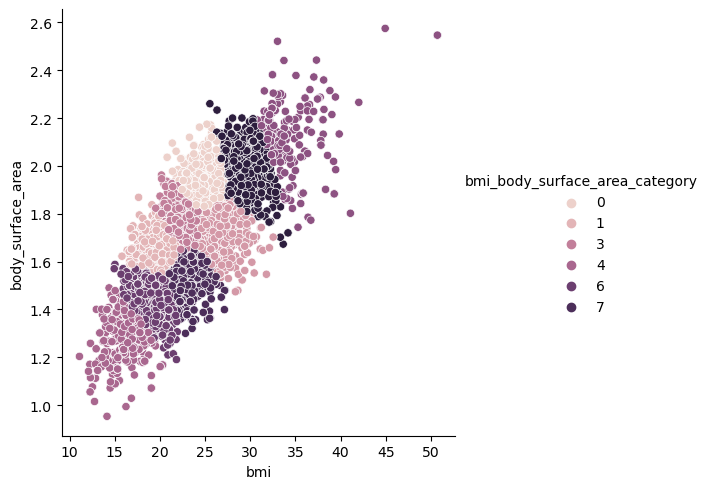

In [114]:
n_clusters = 9
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
sc = StandardScaler()

X = df.loc[:, ['bmi', 'body_surface_area']]
X_std = sc.fit_transform(X)

df['bmi_body_surface_area_category'] = kmeans.fit_predict(X_std)

sns.relplot(x='bmi', y='body_surface_area', hue='bmi_body_surface_area_category', data=df);

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


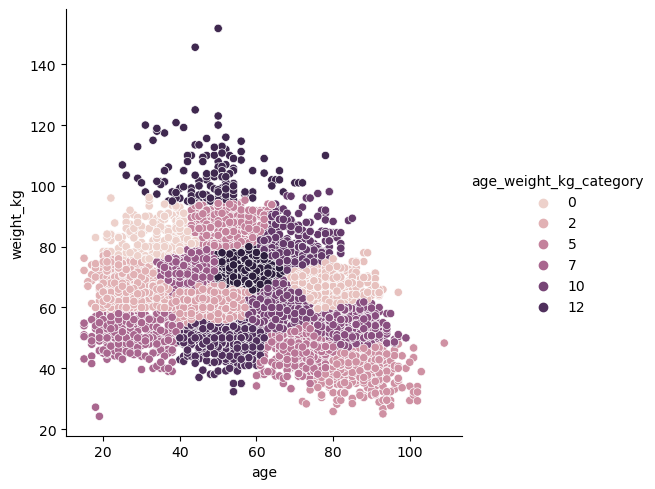

In [116]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
sc = StandardScaler()

X = df.loc[:, ['age', 'weight_kg']]
X_std = sc.fit_transform(X)

df['age_weight_kg_category'] = kmeans.fit_predict(X_std)

sns.relplot(x='age', y='weight_kg', hue='age_weight_kg_category', data=df);

#### scan_areaとscan_methodを組み合わせた特徴量を作成する

In [143]:
df['scan_area_method_combine'] = df['scan_area'] + '_' + df['scan_method']

#### scan_areaとscan_methodとscan_category_bmiを組み合わせた特徴量を作成する

In [144]:
df['scan_area_method_bmi_catgory_combine'] = df['scan_area'] + '_' + df['scan_method']  + '_' + df['category_bmi']

In [145]:
df['bmi_bsa_cat_scan_area_method_combine'] = df['bmi_body_surface_area_category'].astype(str) + df['scan_area_method_combine']

df['age_weight_cat_scan_area_method_combine'] = df['age_weight_kg_category'].astype(str) + df['scan_area_method_combine']

In [147]:
df.to_excel('feature_engineer_train.xlsx', index=False)

In [84]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# 前処理をして相互情報量を計算
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import TargetEncoder

te_columns = [ 'scan_area', 'category_bmi']
oe_columns = ['CTDIw phantom type','gender', 'scan_method']

oe = OrdinalEncoder()
oe.set_output(transform='pandas')

df[oe_columns] = oe.fit_transform(df[oe_columns])

te = TargetEncoder()
te.fit(df[te_columns], df['Mean CTDIvol'])
df[te_columns] = te.transform(df[te_columns])

df.drop(drops, axis=1)

drops = ['Mean CTDIvol', 'accession', 'scan protocol', 'target region', 'scan series', 
         'scanning length', 'kV', 'mean mA', 'max mA', 'pitch factor',
         'nomial total collimation width', 'exposure time per rotation',
         'exposure time', 'Mean CTDIvol', 'DLP', 'study_date', 'id']

target = 'Mean CTDIvol'
mi_scores = make_mi_scores(df.drop(drops, axis=1), df[target], 'auto')

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

ValueError: could not convert string to float: '胸部CT_単純'

In [104]:
df.head(3)

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,...,rate_scan_area x scan_method,rate_category_bmi x gender,rate_age_era x category_bmi,age_era_gender_bmi,age_era_gender_bmr,age_era_gender_bsa,bmi_body_surface_area_category,age_weight_kg_category,scan_area_method_combine,scan_area_method_bmi_catgory_combine
0,1103161420210101,5.1 QQ Chest Routine,NaN,Chest,382.14,100,350.24,640,1.38,80,...,0.973792,0.286558,0.642992,20.40,985.44,1.398293,7,9,胸部CT_単純,胸部CT_単純_normal weight
1,1103161620210101,5.1 QQ Chest Routine,NaN,Chest,442.20,100,442.93,700,1.38,80,...,0.973792,0.841565,0.262165,23.39,1404.54,1.782371,2,3,胸部CT_単純,胸部CT_単純_obesity class1
2,1103339220210102,5.1 QQ Chest Routine,NaN,Chest,467.06,100,306.59,700,1.38,80,...,0.973792,0.713442,0.620907,23.81,1596.91,1.833071,3,0,胸部CT_単純,胸部CT_単純_normal weight
